## Decision Tree Classifer

#### Algorithm Overview

- Decision tree classifers are a type of supervised machine learning algorithms, they can be used for both classification and regression. 
- The algorithm will make decisions based on a series of conditions and are represented in a tree like structure. 
- A decision tree learning employs a divide and conquer strategy by conducting a greedy search to identify the optimal split points within the tree. 
- The preocess of splitting is then repeated in a top-down recursive manner until the majority of records have been classifed
- Decision trees have a preference for small trees - this can avoid overfitting the data

![Decision Tree Structure](image-3.png)

Further Resources
- https://www.ibm.com/topics/decision-trees
- https://www.youtube.com/watch?v=ZVR2Way4nwQ

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [78]:
# Store data as dataframe and display the head (from data stored in file)

column_names = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our',
                'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order',
                'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report',
                'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you',
                'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 
                'word_freq_hp', 'word_freq_hpl', 'word_freq_george','word_freq_650', 'word_freq_lab', 'word_freq_labs',
                 'word_freq_telnet','word_freq_857', 'word_freq_data', 'word_freq_415','word_freq_85','word_freq_technology',
                'word_freq_1999', 'word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting',
                'word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference',
                
                'char_freq_;','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#',
                
                'capital_run_length_average','capital_run_length_longest','capital_run_length_total','spam'
                ]

filepath = '/Users/ejallen/Desktop/Machine_Learning_Project/02_Data/spambase/spambase.data'
df_spam = pd.read_csv(filepath, header=None, names=column_names)

display(df_spam.head())

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [79]:
from sklearn.model_selection import train_test_split

# split the data into training and testing
x = df_spam.drop('spam', axis=1)

y = df_spam.iloc[:,-1].to_numpy().ravel()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Brief Algorithm Description

The basic idea:
1. select the best attribute from an attribute selection measures
2. make that attribute a decision node and break the dataset into smaller subsets
3. start building the tree by repeating this process recursively for each child until one of the conditions is matched 
    - All the tuples belong to the same attribute value 
    - There are no more remaining attributes 
    - There are no more instances

Mathematically, the two main steps are:

1. Calculate the entropy (measure of disorder or uncertainty in a given dataset or system), this is defined by

$$H(S) = \sum_{i=1}^{N}-p_i \log_2(p_i)$$

Where $S$ represents a dataset. 

This is the sum, over all $N$ possible outcomes, of the information from event $i$ multiplied by the probability of the event occurring $p_i$.

2. Calculate the Information gain - this measures the effectiveness of an attribute in classifying the data, it is calculated as the difference between the entropy of the parent set and the weighted sum of the child entropies after the split

$$IG(S, A) = H(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \cdot H(S_v)$$

Where: 

<p> <!-- Paragraph break --></p>

$ IG(S, A) \text{ is the Information Gain for attribute } A \text{ in set } S. $
<p> <!-- Paragraph break --></p>

$ H(S) \text{ is the entropy of set } S. $
<p> <!-- Paragraph break --></p>

$ \text{Values}(A) \text{ represents the possible values of attribute } A. $
<p> <!-- Paragraph break --></p>

$ |S_v| \text{ is the size of the subset of } S \text{ where attribute } A \text{ has value } v. $
<p> <!-- Paragraph break --></p>

$ |S| \text{ is the size of set } S. $
<p> <!-- Paragraph break --></p>

$ H(S_v) \text{ is the entropy of the subset } S_v. $
<p> <!-- Paragraph break --></p>


After the tree is built we make predictions



Further resources 
- https://www.datacamp.com/tutorial/decision-tree-classification-python


#### Pipelines

A pipeline is a way to streamline a lot of the routine processes in a machine learning workflow. 

- *Documentation* - https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- *Example with PCA and logistic regression* - https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

#### K Fold Validation

we split our x_train into k different folds to train the data and repeat the training K times

In [80]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k = 0
best_score = 0  

# Convert x_train and y_train to numpy arrays
X_train_val = np.array(x_train)
y_train_val = np.array(y_train)

# Loop over sections of data
for idx_train, idx_val in kf.split(X_train_val):
    X_train_k, X_val = X_train_val[idx_train], X_train_val[idx_val]
    y_train_k, y_val = y_train_val[idx_train], y_train_val[idx_val]

    # Use the pipeline to train a new model
    decisionTreeModel = DecisionTreeClassifier(random_state=42, # random state set to ensure results are consistent across different runs of the model
                                           max_depth=12,
                                           splitter='best', 
                                           criterion='gini',       
                                           min_samples_leaf=1, 
                                           min_samples_split=2,
                                           ccp_alpha=0.001
                                            )                               
    
    pipe = Pipeline([('scaler', StandardScaler()), ('decision_tree', decisionTreeModel)])
    pipe.fit(X_train_k, y_train_k)
    y_pred_lr = pipe.predict(X_val)

    # Calculate accuracy for the validation set
    accuracy = accuracy_score(y_val, y_pred_lr)
    print(f"Fold {k}: Accuracy for decision tree model (with scaling): {accuracy}\n")
    k += 1

    if accuracy > best_score:
        best_model = copy.deepcopy(pipe)
        best_score = accuracy

# calculate accuracy for the best model and predict y values 
X_test_scaled = best_model['scaler'].transform(x_test)
y_pred = best_model['decision_tree'].predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy for decision tree model (with scaling) on test set: {test_accuracy}\n")

# make and print classification report
classification_report_result = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_report_result)

Fold 0: Accuracy for decision tree model (with scaling): 0.9144021739130435

Fold 1: Accuracy for decision tree model (with scaling): 0.8980978260869565

Fold 2: Accuracy for decision tree model (with scaling): 0.9184782608695652

Fold 3: Accuracy for decision tree model (with scaling): 0.9184782608695652

Fold 4: Accuracy for decision tree model (with scaling): 0.9334239130434783


Accuracy for decision tree model (with scaling) on test set: 0.9185667752442996

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       531
           1       0.94      0.86      0.90       390

    accuracy                           0.92       921
   macro avg       0.92      0.91      0.92       921
weighted avg       0.92      0.92      0.92       921



/Users/ejallen/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Learning Curve 

A learning curve provides a visual representation of a model's performance as it learns from training data, depicting how training and validation (or test) errors evolve with changes in the size of the training dataset. 
Analysing learning curves helps identify issues like overfitting, underfitting, and the impact of dataset size on a model's ability to generalize to new data.

Bias:
- Bias is an error introduced by approximating a real-world problem too simplistically
- defined as the differenced between the predicted values and the true values
- High bias models lead to underfitting the data

Variance:
- Variance is the amount that a models predictions vary for different training sets, it measures the models sensitivity to the training data
- high variance models lead to overfitting

Resources:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
- https://www.youtube.com/watch?v=lYAV5KNk_TY

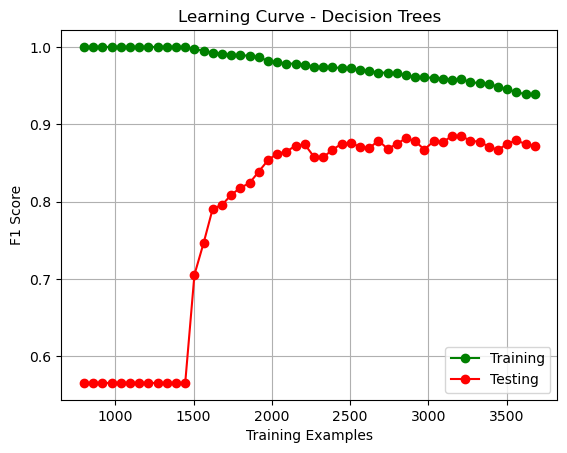

In [102]:
from sklearn.model_selection import learning_curve

def draw_learning_curves(X, y, estimator, num_trainings):

    # Start the plot at 1250 training examples - from running multiple times, both curves are straight lines until roughly 1500
    start_training_size = 1250
    train_sizes, train_scores, test_scores = learning_curve(
                                                            estimator=estimator,
                                                            X=X,
                                                            y=y,
                                                            cv=5,
                                                            n_jobs=1,
                                                            train_sizes=np.linspace(start_training_size / len(X), 1.0, num_trainings),
                                                            scoring='f1'
                                                            )
    
    train_score_mean = np.mean(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)

    plt.grid()
    plt.plot(train_sizes, train_score_mean, 'o-', color='g', label='Training')
    plt.plot(train_sizes, test_score_mean, 'o-', color='r', label='Testing')
    plt.title('Learning Curve - Decision Trees')
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

# Note: This might take a while to run, especially with a large number of num_trainings
draw_learning_curves(x, y, best_model, num_trainings=50)

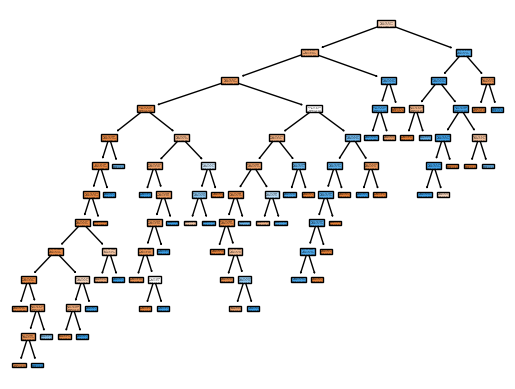

In [82]:
from sklearn import tree

#draw the decision tree:
fig = tree.plot_tree(decisionTreeModel, filled=True)
plt.show()

#### Confusion Matrix 

The confusion matrix is a matrix that summarises the performance of a machine learning model on a set of test data. 

- The top left represents the TP, true positive 
- The top right represents the FP - false positive 
- The bottom left represents the FN - false negative 
- The bottom right represents the TN - true negative 

Hence for a more accurate model, we expect the values in the FP and FN to be small

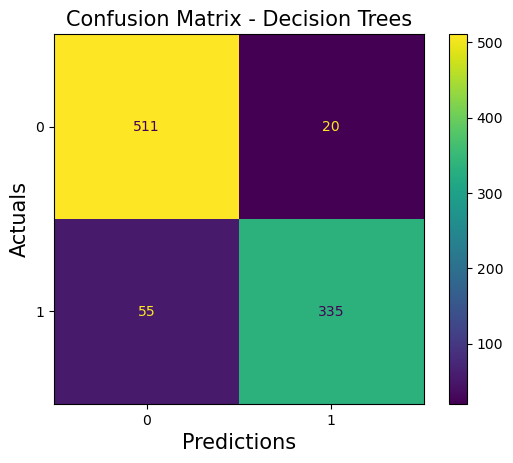

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix 
confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix)
conf_matrix.plot()
 
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('Confusion Matrix - Decision Trees', fontsize=15)
plt.show()

#### ROC Curve (Receiver Operating Characteristic Curve)

This a graph showing the performance of a classification model at all classification thresholds, the curve plots two parameters 

1. True Positive Rate (TPR)

$$ TPR = \frac{\text{True Positives }}{\text{ True Positives } + \text{ False Negatives}} $$

2. False Positive Rate (FPR)

$$ FPR = \frac{\text{False Positives }}{\text{ False Positives } + \text{ True Negatives}} $$


Further Resources:
- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc


/Users/ejallen/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


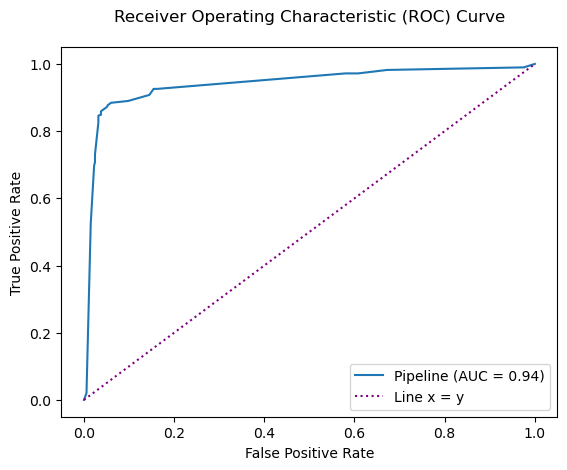

In [84]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

metrics.RocCurveDisplay.from_estimator(estimator=best_model, X=x_test, y=y_test)

# superimposed diagonal line for comparison
x_line = np.linspace(0, 1, 100)
plt.plot(x_line, x_line, label='Line x = y', color='purple', linestyle='dotted')

plt.title('Receiver Operating Characteristic (ROC) Curve\n')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Area Under the ROC Curve (AUC)

The AUC measures the whole two-dimenstional area underneath the ROC curve, it ranges form 0.0 to 1.0
The provides a measure of performance across all classification thresholds. It can be 
interpreted as the probability that the model ranks a random positive example more highly that a random negative example
100% wrong would mean an AUC of 0.0 and 100% right would mean an AUC of 1.0. 

Two features of AUC are:

1. Scale Invariant
    + it measures how well predictions are ranked rather than their absolute values 
    - sometimes we need well calibrated probability outputs and the AUC will not tell us about this 

<p> <!-- Paragraph break --></p>

2. Classification- Threshold invariant:
    + it measures the quality of the model's predictions irrespective of what classification threshold is chosen 
    - this is not always desirable, especially in cases where there are wide disparities in the cost of false negative vs false positives. 

<p> <!-- Paragraph break --></p>

Further Resources:
- https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [85]:
# Compute ROC curve and AUC
y_probs = best_model.predict_proba(x_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_probs)

print(f'The Area under the ROC Curve (AUC) is {auc_roc}')

The Area under the ROC Curve (AUC) is 0.9401516248973876


/Users/ejallen/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Matthews Correlation Coefficient (MCC) 

- The Matthews Correlation Coefficient (MCC) is a metri that takes into account all four values in the confusion matrix to 
provide a balanced measure of the classification performance 
- It ranges from -1 to 1, where 1 indicates a perfect prediction, 0 represents no better than random and -1 indicates total disagreement between prediction and observation
- Formula is given by:

$$ \text{MCC} = \frac{\text{TP} \times \text{TN} - \text{FP} \times \text{FN}}{\sqrt{(\text{TP} + \text{FP}) \times (\text{TP} + \text{FN}) \times (\text{TN} + \text{FP}) \times (\text{TN} + \text{FN})}} $$



In [86]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
print(f'the Matthews Correlation Coefficient is {mcc}')

the Matthews Correlation Coefficient is 0.8338041611621371


#### Cohen's Kappa

Cohen's Kappa is used to evaulate the agreement between the predicted and true class while account for the possibiilty of agreement occuring by chance. This is particularly useful for imbalanced datasets. It is calculated by:


$$\kappa = \frac{P_o - P_e}{1 - P_e}$$

Where:
- $P_o$ is the observed agreement
- $P_e$ is the expected agreement by chance.

Resources:
- https://en.wikipedia.org/wiki/Cohen%27s_kappa
- https://thenewstack.io/cohens-kappa-what-it-is-when-to-use-it-and-how-to-avoid-its-pitfalls/

In [87]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.831213576219624
